In [1]:
###Import libraries###
from itertools import groupby
from rdkit import Chem
#rom utils import OCAD_SDF_reader
import numpy as np
from utils import *
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
from rdkit.Chem import Descriptors
from rdkit.Chem.inchi import *
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from custom_layers import *
from model import *

#remove RDKit warnings
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
OCAD_SDF_PATH = './e-OCAD2022.sdf'
OCAD_entries = get_sdf_entries(OCAD_SDF_PATH)

In [3]:
%%time
OCAD_SDF_entries_tuples = [tuple(vars(OCAD_SDF_reader(x)).values())[2:] for x in OCAD_entries]
names = list(vars(OCAD_SDF_reader(OCAD_entries[0])).keys())[2:]
OCAD_df = pd.DataFrame(OCAD_SDF_entries_tuples, columns =names)

Wall time: 1.2 s


In [4]:
OCAD_df = OCAD_df[['mw', 'spectrum', 'neutral_loss', 'name', 'inchikey', 'smiles', 'schedule', 'max_mz']]

In [5]:
df=OCAD_df

In [6]:
### Remove deuterated molecules
df = df[df.smiles.apply(lambda x: x.find('[H]')==-1)]

In [7]:
df = df.drop_duplicates(subset='smiles', keep='first')

In [8]:
df['mol']=df.smiles.apply(Chem.MolFromSmiles)
df=df[df.mol.isnull()==False]

In [9]:
df=df[df.spectrum.isnull()==False]
df=df[df.neutral_loss.isnull()==False]


In [10]:
df = df.reset_index(drop=True)

In [11]:
x=graphs_from_smiles(df.smiles)
m_s = np.arange(0, 560)**0.5
m_n = np.flip(m_s)
#y_s = df.spectrum.values
#y_n = df.neutral_loss.values
y_s = df.spectrum.apply(lambda x: m_s*x**0.5).values
y_n = df.neutral_loss.apply(lambda x: m_n*x**0.5).values

In [12]:
###Here cross-validation fold should be changed 
Fold=4

In [13]:

#get an independent test set (one for all CV splits)
train_len = int(df.shape[0]*0.8)
permuted_indices = np.random.permutation(np.arange(df.shape[0]))
index = np.array_split(permuted_indices[: int(df.shape[0] * 0.8)],5)
train_index = np.hstack([index[i] for i in range(len(index)) if i!=False])


valid_index = index[Fold]
test_index = permuted_indices[int(df.shape[0] * 0.80) :]

X = [x[i][train_index]for i in range(len(x))]
x_valid = [x[i][valid_index] for i in range(len(x))]
x_test = [x[i][test_index] for i in range(len(x))]


Y_s = y_s[train_index]
y_valid_s = y_s[valid_index]
y_test_s = y_s[test_index]
Y_n = y_n[train_index]
y_valid_n = y_n[valid_index]
y_test_n = y_n[test_index]

In [14]:
print(df.shape)
print(Y_s.shape)
print(y_valid_s.shape)
print(y_test_s.shape)

(4642, 9)
(2970,)
(742,)
(929,)


In [15]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
i=0

In [16]:
import tensorflow as tf

def customLoss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    cos = tf.keras.losses.CosineSimilarity()
    return - (r_num / r_den)**2-cos(x,y)**2

In [17]:
train_dataset_s = MPNNDataset(X, np.vstack(Y_s))
valid_dataset_s = MPNNDataset(x_valid, np.vstack(y_valid_s))
test_dataset_s = MPNNDataset(x_test, np.vstack(y_test_s))


In [18]:
from keras.callbacks import ReduceLROnPlateau
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

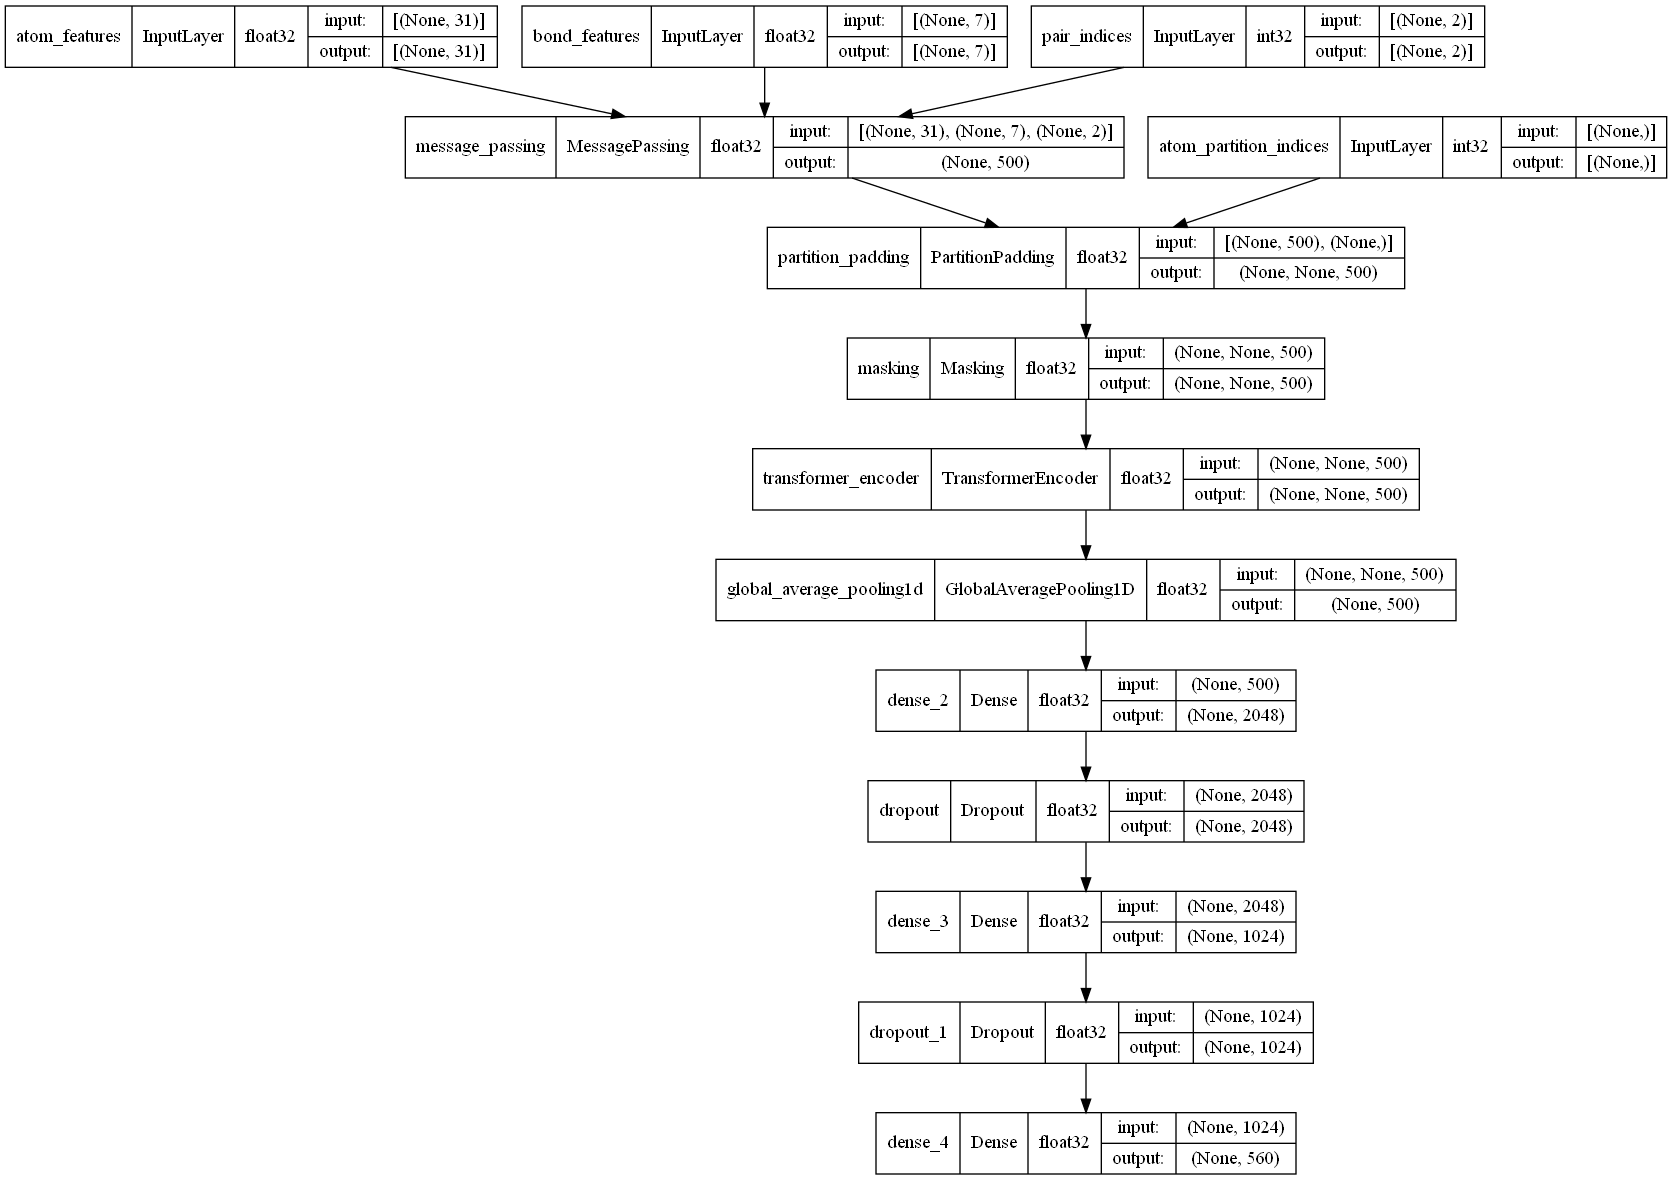

In [19]:
mpnn_s = MPNNModel(atom_dim=X[0][0][0].shape[0], bond_dim=X[1][0][0].shape[0])
mpnn_s.compile(
    loss=customLoss,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[keras.metrics.CosineSimilarity(name="cosine_similarity")],
)

keras.utils.plot_model(mpnn_s, show_dtype=True, show_shapes=True)

In [20]:
history = mpnn_s.fit(
train_dataset_s,
validation_data=valid_dataset_s,
epochs=500, callbacks = [callback, rlrop],
verbose=2)

Epoch 1/500
93/93 - 15s - loss: -2.6984e-01 - cosine_similarity: 0.3871 - val_loss: -3.8149e-01 - val_cosine_similarity: 0.4619 - lr: 1.0000e-04 - 15s/epoch - 166ms/step
Epoch 2/500
93/93 - 12s - loss: -4.5609e-01 - cosine_similarity: 0.5011 - val_loss: -6.1849e-01 - val_cosine_similarity: 0.5766 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 3/500
93/93 - 12s - loss: -6.1360e-01 - cosine_similarity: 0.5747 - val_loss: -7.2642e-01 - val_cosine_similarity: 0.6207 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 4/500
93/93 - 12s - loss: -6.7661e-01 - cosine_similarity: 0.6015 - val_loss: -7.6082e-01 - val_cosine_similarity: 0.6343 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 5/500
93/93 - 12s - loss: -7.5217e-01 - cosine_similarity: 0.6329 - val_loss: -8.8104e-01 - val_cosine_similarity: 0.6814 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 6/500
93/93 - 12s - loss: -8.3887e-01 - cosine_similarity: 0.6683 - val_loss: -1.0004e+00 - val_cosine_similarity: 0.7243 - lr: 1.0000e-04 - 12s

Epoch 49/500
93/93 - 12s - loss: -1.6332e+00 - cosine_similarity: 0.9116 - val_loss: -1.6760e+00 - val_cosine_similarity: 0.9221 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 50/500
93/93 - 12s - loss: -1.6397e+00 - cosine_similarity: 0.9133 - val_loss: -1.6745e+00 - val_cosine_similarity: 0.9219 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 51/500
93/93 - 12s - loss: -1.6486e+00 - cosine_similarity: 0.9156 - val_loss: -1.6893e+00 - val_cosine_similarity: 0.9251 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 52/500
93/93 - 12s - loss: -1.6570e+00 - cosine_similarity: 0.9177 - val_loss: -1.6901e+00 - val_cosine_similarity: 0.9254 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 53/500
93/93 - 12s - loss: -1.6623e+00 - cosine_similarity: 0.9187 - val_loss: -1.6824e+00 - val_cosine_similarity: 0.9238 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 54/500
93/93 - 12s - loss: -1.6700e+00 - cosine_similarity: 0.9205 - val_loss: -1.7095e+00 - val_cosine_similarity: 0.9303 - lr: 1.0000e-04

Epoch 97/500
93/93 - 12s - loss: -1.8146e+00 - cosine_similarity: 0.9552 - val_loss: -1.8629e+00 - val_cosine_similarity: 0.9664 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 98/500
93/93 - 12s - loss: -1.8165e+00 - cosine_similarity: 0.9556 - val_loss: -1.8594e+00 - val_cosine_similarity: 0.9658 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 99/500
93/93 - 12s - loss: -1.8180e+00 - cosine_similarity: 0.9560 - val_loss: -1.8663e+00 - val_cosine_similarity: 0.9676 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 100/500
93/93 - 12s - loss: -1.8208e+00 - cosine_similarity: 0.9567 - val_loss: -1.8684e+00 - val_cosine_similarity: 0.9678 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 101/500
93/93 - 12s - loss: -1.8223e+00 - cosine_similarity: 0.9571 - val_loss: -1.8698e+00 - val_cosine_similarity: 0.9681 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 102/500
93/93 - 12s - loss: -1.8230e+00 - cosine_similarity: 0.9574 - val_loss: -1.8711e+00 - val_cosine_similarity: 0.9686 - lr: 1.0000e

Epoch 145/500
93/93 - 12s - loss: -1.8669e+00 - cosine_similarity: 0.9680 - val_loss: -1.9111e+00 - val_cosine_similarity: 0.9784 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 146/500
93/93 - 12s - loss: -1.8656e+00 - cosine_similarity: 0.9678 - val_loss: -1.9104e+00 - val_cosine_similarity: 0.9783 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 147/500
93/93 - 12s - loss: -1.8676e+00 - cosine_similarity: 0.9682 - val_loss: -1.9028e+00 - val_cosine_similarity: 0.9765 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 148/500
93/93 - 12s - loss: -1.8685e+00 - cosine_similarity: 0.9684 - val_loss: -1.9073e+00 - val_cosine_similarity: 0.9774 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 149/500
93/93 - 12s - loss: -1.8663e+00 - cosine_similarity: 0.9679 - val_loss: -1.9070e+00 - val_cosine_similarity: 0.9773 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 150/500
93/93 - 12s - loss: -1.8712e+00 - cosine_similarity: 0.9691 - val_loss: -1.9156e+00 - val_cosine_similarity: 0.9796 - lr: 1.00

Epoch 193/500
93/93 - 12s - loss: -1.9022e+00 - cosine_similarity: 0.9765 - val_loss: -1.9413e+00 - val_cosine_similarity: 0.9857 - lr: 5.0000e-05 - 12s/epoch - 127ms/step
Epoch 194/500
93/93 - 12s - loss: -1.9022e+00 - cosine_similarity: 0.9765 - val_loss: -1.9410e+00 - val_cosine_similarity: 0.9856 - lr: 5.0000e-05 - 12s/epoch - 127ms/step
Epoch 195/500
93/93 - 12s - loss: -1.9033e+00 - cosine_similarity: 0.9768 - val_loss: -1.9422e+00 - val_cosine_similarity: 0.9859 - lr: 5.0000e-05 - 12s/epoch - 128ms/step
Epoch 196/500
93/93 - 12s - loss: -1.9034e+00 - cosine_similarity: 0.9768 - val_loss: -1.9429e+00 - val_cosine_similarity: 0.9861 - lr: 5.0000e-05 - 12s/epoch - 127ms/step
Epoch 197/500
93/93 - 12s - loss: -1.9037e+00 - cosine_similarity: 0.9769 - val_loss: -1.9420e+00 - val_cosine_similarity: 0.9859 - lr: 5.0000e-05 - 12s/epoch - 128ms/step
Epoch 198/500
93/93 - 12s - loss: -1.9035e+00 - cosine_similarity: 0.9768 - val_loss: -1.9430e+00 - val_cosine_similarity: 0.9861 - lr: 5.00

Epoch 241/500
93/93 - 12s - loss: -1.9150e+00 - cosine_similarity: 0.9796 - val_loss: -1.9524e+00 - val_cosine_similarity: 0.9884 - lr: 2.5000e-05 - 12s/epoch - 127ms/step
Epoch 242/500
93/93 - 12s - loss: -1.9146e+00 - cosine_similarity: 0.9795 - val_loss: -1.9531e+00 - val_cosine_similarity: 0.9885 - lr: 2.5000e-05 - 12s/epoch - 127ms/step
Epoch 243/500
93/93 - 12s - loss: -1.9155e+00 - cosine_similarity: 0.9797 - val_loss: -1.9525e+00 - val_cosine_similarity: 0.9884 - lr: 2.5000e-05 - 12s/epoch - 127ms/step
Epoch 244/500
93/93 - 12s - loss: -1.9150e+00 - cosine_similarity: 0.9796 - val_loss: -1.9521e+00 - val_cosine_similarity: 0.9883 - lr: 2.5000e-05 - 12s/epoch - 127ms/step
Epoch 245/500
93/93 - 12s - loss: -1.9146e+00 - cosine_similarity: 0.9796 - val_loss: -1.9526e+00 - val_cosine_similarity: 0.9884 - lr: 2.5000e-05 - 12s/epoch - 127ms/step
Epoch 246/500
93/93 - 12s - loss: -1.9158e+00 - cosine_similarity: 0.9798 - val_loss: -1.9527e+00 - val_cosine_similarity: 0.9884 - lr: 2.50

Epoch 289/500
93/93 - 12s - loss: -1.9199e+00 - cosine_similarity: 0.9808 - val_loss: -1.9569e+00 - val_cosine_similarity: 0.9894 - lr: 1.5625e-06 - 12s/epoch - 127ms/step
Epoch 290/500
93/93 - 12s - loss: -1.9208e+00 - cosine_similarity: 0.9810 - val_loss: -1.9570e+00 - val_cosine_similarity: 0.9894 - lr: 1.5625e-06 - 12s/epoch - 127ms/step
Epoch 291/500
93/93 - 12s - loss: -1.9209e+00 - cosine_similarity: 0.9810 - val_loss: -1.9569e+00 - val_cosine_similarity: 0.9894 - lr: 1.5625e-06 - 12s/epoch - 127ms/step
Epoch 292/500
93/93 - 12s - loss: -1.9202e+00 - cosine_similarity: 0.9809 - val_loss: -1.9570e+00 - val_cosine_similarity: 0.9894 - lr: 7.8125e-07 - 12s/epoch - 127ms/step
Epoch 293/500
93/93 - 12s - loss: -1.9208e+00 - cosine_similarity: 0.9810 - val_loss: -1.9570e+00 - val_cosine_similarity: 0.9894 - lr: 7.8125e-07 - 12s/epoch - 127ms/step
Epoch 294/500
93/93 - 12s - loss: -1.9197e+00 - cosine_similarity: 0.9808 - val_loss: -1.9570e+00 - val_cosine_similarity: 0.9894 - lr: 7.81

In [21]:
train_dataset_n = MPNNDataset(X, np.vstack(Y_n))
valid_dataset_n= MPNNDataset(x_valid, np.vstack(y_valid_n))
test_dataset_n= MPNNDataset(x_test, np.vstack(y_test_n))

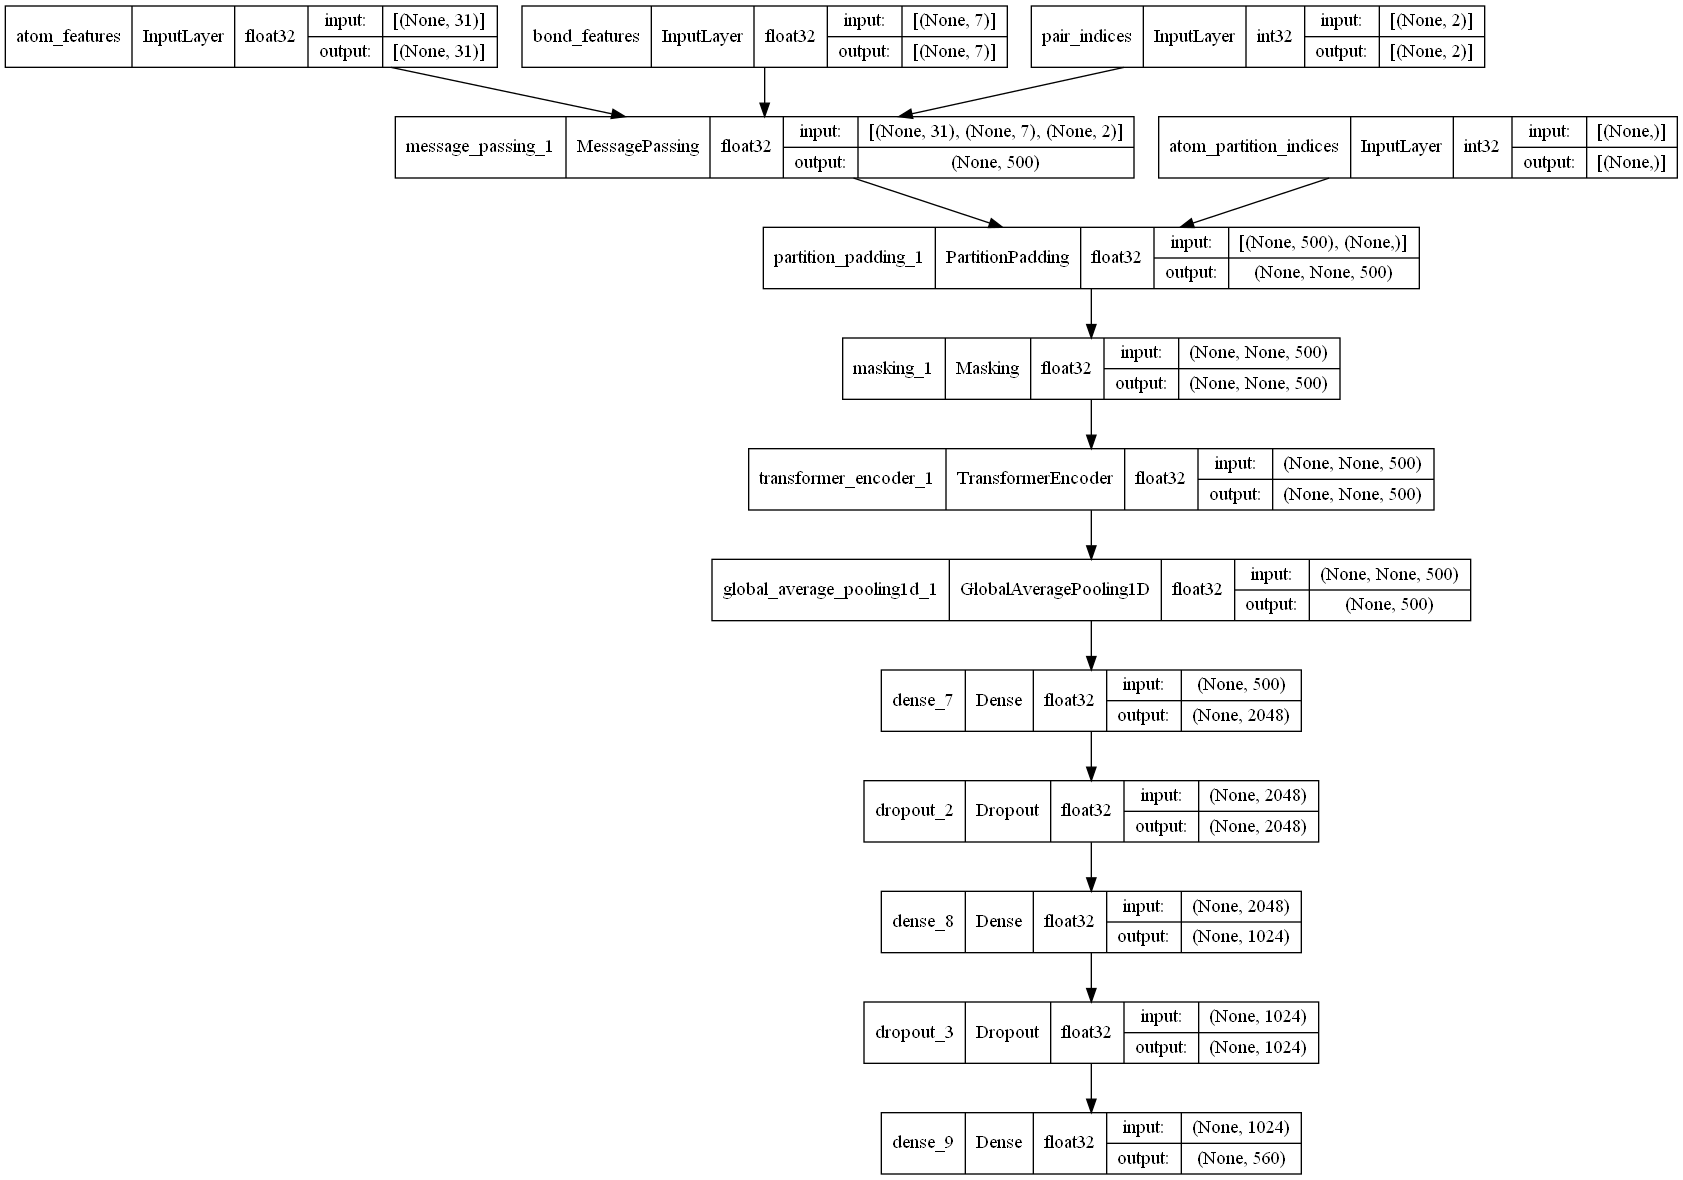

In [22]:
mpnn_n = MPNNModel(atom_dim=X[0][0][0].shape[0], bond_dim=X[1][0][0].shape[0])
mpnn_n.compile(
    loss=customLoss,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[keras.metrics.CosineSimilarity(name="cosine_similarity")],
)

keras.utils.plot_model(mpnn_n, show_dtype=True, show_shapes=True)

In [23]:
history = mpnn_n.fit(
train_dataset_n,
validation_data=valid_dataset_n,
epochs=500, callbacks = [callback,rlrop],
verbose=2)

Epoch 1/500
93/93 - 15s - loss: -2.3445e-01 - cosine_similarity: 0.3619 - val_loss: -3.4074e-01 - val_cosine_similarity: 0.4308 - lr: 1.0000e-04 - 15s/epoch - 159ms/step
Epoch 2/500
93/93 - 12s - loss: -3.8463e-01 - cosine_similarity: 0.4578 - val_loss: -4.7886e-01 - val_cosine_similarity: 0.5065 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 3/500
93/93 - 12s - loss: -4.7057e-01 - cosine_similarity: 0.5028 - val_loss: -5.6908e-01 - val_cosine_similarity: 0.5499 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 4/500
93/93 - 12s - loss: -5.2648e-01 - cosine_similarity: 0.5293 - val_loss: -6.1469e-01 - val_cosine_similarity: 0.5690 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 5/500
93/93 - 12s - loss: -5.8092e-01 - cosine_similarity: 0.5534 - val_loss: -6.8998e-01 - val_cosine_similarity: 0.6011 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 6/500
93/93 - 12s - loss: -6.3096e-01 - cosine_similarity: 0.5763 - val_loss: -7.4516e-01 - val_cosine_similarity: 0.6239 - lr: 1.0000e-04 - 12s

Epoch 49/500
93/93 - 12s - loss: -1.4665e+00 - cosine_similarity: 0.8631 - val_loss: -1.5731e+00 - val_cosine_similarity: 0.8923 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 50/500
93/93 - 12s - loss: -1.4721e+00 - cosine_similarity: 0.8646 - val_loss: -1.5699e+00 - val_cosine_similarity: 0.8909 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 51/500
93/93 - 12s - loss: -1.4746e+00 - cosine_similarity: 0.8653 - val_loss: -1.5785e+00 - val_cosine_similarity: 0.8932 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 52/500
93/93 - 12s - loss: -1.4780e+00 - cosine_similarity: 0.8657 - val_loss: -1.5960e+00 - val_cosine_similarity: 0.8976 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 53/500
93/93 - 12s - loss: -1.4870e+00 - cosine_similarity: 0.8682 - val_loss: -1.5915e+00 - val_cosine_similarity: 0.8963 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 54/500
93/93 - 12s - loss: -1.5048e+00 - cosine_similarity: 0.8734 - val_loss: -1.6052e+00 - val_cosine_similarity: 0.9000 - lr: 1.0000e-04

Epoch 97/500
93/93 - 12s - loss: -1.7023e+00 - cosine_similarity: 0.9256 - val_loss: -1.7786e+00 - val_cosine_similarity: 0.9444 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 98/500
93/93 - 12s - loss: -1.7076e+00 - cosine_similarity: 0.9270 - val_loss: -1.7911e+00 - val_cosine_similarity: 0.9478 - lr: 1.0000e-04 - 12s/epoch - 128ms/step
Epoch 99/500
93/93 - 12s - loss: -1.7086e+00 - cosine_similarity: 0.9274 - val_loss: -1.7770e+00 - val_cosine_similarity: 0.9442 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 100/500
93/93 - 12s - loss: -1.7070e+00 - cosine_similarity: 0.9269 - val_loss: -1.7900e+00 - val_cosine_similarity: 0.9478 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 101/500
93/93 - 12s - loss: -1.7148e+00 - cosine_similarity: 0.9290 - val_loss: -1.7879e+00 - val_cosine_similarity: 0.9470 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 102/500
93/93 - 12s - loss: -1.7092e+00 - cosine_similarity: 0.9273 - val_loss: -1.7934e+00 - val_cosine_similarity: 0.9487 - lr: 1.0000e

Epoch 145/500
93/93 - 12s - loss: -1.7880e+00 - cosine_similarity: 0.9471 - val_loss: -1.8573e+00 - val_cosine_similarity: 0.9643 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 146/500
93/93 - 12s - loss: -1.7957e+00 - cosine_similarity: 0.9493 - val_loss: -1.8605e+00 - val_cosine_similarity: 0.9649 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 147/500
93/93 - 12s - loss: -1.7882e+00 - cosine_similarity: 0.9479 - val_loss: -1.8505e+00 - val_cosine_similarity: 0.9629 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 148/500
93/93 - 12s - loss: -1.7838e+00 - cosine_similarity: 0.9464 - val_loss: -1.8443e+00 - val_cosine_similarity: 0.9614 - lr: 1.0000e-04 - 12s/epoch - 127ms/step
Epoch 149/500
93/93 - 13s - loss: -1.7918e+00 - cosine_similarity: 0.9484 - val_loss: -1.8688e+00 - val_cosine_similarity: 0.9674 - lr: 1.0000e-04 - 13s/epoch - 140ms/step
Epoch 150/500
93/93 - 12s - loss: -1.7942e+00 - cosine_similarity: 0.9489 - val_loss: -1.8677e+00 - val_cosine_similarity: 0.9672 - lr: 1.00

Epoch 193/500
93/93 - 12s - loss: -1.8482e+00 - cosine_similarity: 0.9626 - val_loss: -1.9105e+00 - val_cosine_similarity: 0.9776 - lr: 5.0000e-05 - 12s/epoch - 133ms/step
Epoch 194/500
93/93 - 12s - loss: -1.8476e+00 - cosine_similarity: 0.9624 - val_loss: -1.9093e+00 - val_cosine_similarity: 0.9773 - lr: 5.0000e-05 - 12s/epoch - 133ms/step
Epoch 195/500
93/93 - 12s - loss: -1.8486e+00 - cosine_similarity: 0.9628 - val_loss: -1.9103e+00 - val_cosine_similarity: 0.9775 - lr: 5.0000e-05 - 12s/epoch - 133ms/step
Epoch 196/500
93/93 - 12s - loss: -1.8480e+00 - cosine_similarity: 0.9625 - val_loss: -1.9124e+00 - val_cosine_similarity: 0.9781 - lr: 5.0000e-05 - 12s/epoch - 133ms/step
Epoch 197/500
93/93 - 12s - loss: -1.8497e+00 - cosine_similarity: 0.9629 - val_loss: -1.9116e+00 - val_cosine_similarity: 0.9779 - lr: 5.0000e-05 - 12s/epoch - 133ms/step
Epoch 198/500
93/93 - 12s - loss: -1.8494e+00 - cosine_similarity: 0.9629 - val_loss: -1.9112e+00 - val_cosine_similarity: 0.9778 - lr: 5.00

Epoch 241/500
93/93 - 12s - loss: -1.8694e+00 - cosine_similarity: 0.9678 - val_loss: -1.9294e+00 - val_cosine_similarity: 0.9823 - lr: 1.2500e-05 - 12s/epoch - 133ms/step
Epoch 242/500
93/93 - 12s - loss: -1.8701e+00 - cosine_similarity: 0.9680 - val_loss: -1.9296e+00 - val_cosine_similarity: 0.9823 - lr: 1.2500e-05 - 12s/epoch - 133ms/step
Epoch 243/500
93/93 - 12s - loss: -1.8689e+00 - cosine_similarity: 0.9677 - val_loss: -1.9293e+00 - val_cosine_similarity: 0.9822 - lr: 1.2500e-05 - 12s/epoch - 133ms/step
Epoch 244/500
93/93 - 12s - loss: -1.8686e+00 - cosine_similarity: 0.9677 - val_loss: -1.9301e+00 - val_cosine_similarity: 0.9825 - lr: 1.2500e-05 - 12s/epoch - 133ms/step
Epoch 245/500
93/93 - 12s - loss: -1.8699e+00 - cosine_similarity: 0.9680 - val_loss: -1.9303e+00 - val_cosine_similarity: 0.9825 - lr: 1.2500e-05 - 12s/epoch - 134ms/step
Epoch 246/500
93/93 - 12s - loss: -1.8688e+00 - cosine_similarity: 0.9677 - val_loss: -1.9297e+00 - val_cosine_similarity: 0.9823 - lr: 1.25

Epoch 289/500
93/93 - 12s - loss: -1.8746e+00 - cosine_similarity: 0.9691 - val_loss: -1.9337e+00 - val_cosine_similarity: 0.9833 - lr: 3.1250e-06 - 12s/epoch - 127ms/step
Epoch 290/500
93/93 - 12s - loss: -1.8738e+00 - cosine_similarity: 0.9689 - val_loss: -1.9337e+00 - val_cosine_similarity: 0.9833 - lr: 3.1250e-06 - 12s/epoch - 127ms/step
Epoch 291/500
93/93 - 12s - loss: -1.8743e+00 - cosine_similarity: 0.9691 - val_loss: -1.9338e+00 - val_cosine_similarity: 0.9833 - lr: 3.1250e-06 - 12s/epoch - 127ms/step
Epoch 292/500
93/93 - 12s - loss: -1.8731e+00 - cosine_similarity: 0.9688 - val_loss: -1.9336e+00 - val_cosine_similarity: 0.9833 - lr: 3.1250e-06 - 12s/epoch - 127ms/step
Epoch 293/500
93/93 - 12s - loss: -1.8743e+00 - cosine_similarity: 0.9690 - val_loss: -1.9337e+00 - val_cosine_similarity: 0.9833 - lr: 3.1250e-06 - 12s/epoch - 127ms/step
Epoch 294/500
93/93 - 12s - loss: -1.8738e+00 - cosine_similarity: 0.9689 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9834 - lr: 3.12

Epoch 337/500
93/93 - 12s - loss: -1.8748e+00 - cosine_similarity: 0.9691 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9833 - lr: 1.2207e-08 - 12s/epoch - 127ms/step
Epoch 338/500
93/93 - 12s - loss: -1.8754e+00 - cosine_similarity: 0.9693 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9833 - lr: 1.2207e-08 - 12s/epoch - 127ms/step
Epoch 339/500
93/93 - 12s - loss: -1.8746e+00 - cosine_similarity: 0.9691 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9833 - lr: 1.2207e-08 - 12s/epoch - 127ms/step
Epoch 340/500
93/93 - 12s - loss: -1.8751e+00 - cosine_similarity: 0.9692 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9833 - lr: 1.2207e-08 - 12s/epoch - 127ms/step
Epoch 341/500
93/93 - 12s - loss: -1.8747e+00 - cosine_similarity: 0.9692 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9833 - lr: 1.2207e-08 - 12s/epoch - 127ms/step
Epoch 342/500
93/93 - 12s - loss: -1.8745e+00 - cosine_similarity: 0.9691 - val_loss: -1.9339e+00 - val_cosine_similarity: 0.9833 - lr: 6.10

In [24]:
train_df = df.iloc[train_index]
valid_df = df.iloc[valid_index]
test_df = df.iloc[test_index]

In [25]:
train_spec_pred = mpnn_s.predict(train_dataset_s)
train_nl_pred = mpnn_n.predict(train_dataset_n)


valid_spec_pred = mpnn_s.predict(valid_dataset_s)
valid_nl_pred = mpnn_n.predict(valid_dataset_n)


test_spec_pred = mpnn_s.predict(test_dataset_s)
test_nl_pred = mpnn_n.predict(test_dataset_n)

In [26]:
train_df['pred_s'] = list(train_spec_pred)
train_df['pred_n'] = list(train_nl_pred)

valid_df['pred_s'] = list(valid_spec_pred)
valid_df['pred_n'] = list(valid_nl_pred)

test_df['pred_s'] = list(test_spec_pred)
test_df['pred_n'] = list(test_nl_pred)

In [27]:
m_s[0]=1
m_n[-1]=1


In [28]:
train_df['pred_s'] = train_df['pred_s'].apply(lambda x:x**2/m_s)
train_df['pred_n'] = train_df['pred_n'].apply(lambda x:x**2/m_n)

valid_df['pred_s'] = valid_df['pred_s'].apply(lambda x:x**2/m_s)
valid_df['pred_n'] = valid_df['pred_n'].apply(lambda x:x**2/m_n)

test_df['pred_s'] = test_df['pred_s'].apply(lambda x:x**2/m_s)
test_df['pred_n'] = test_df['pred_n'].apply(lambda x:x**2/m_n)

In [29]:
def cs(x,y):
    return (np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))**2

In [30]:
train_df['cs_s'] = train_df.apply(lambda x: cs(x.pred_s, x.spectrum), axis=1)
train_df['cs_n'] = train_df.apply(lambda x: cs(x.pred_n, x.neutral_loss), axis=1)

valid_df['cs_s'] = valid_df.apply(lambda x: cs(x.pred_s, x.spectrum), axis=1)
valid_df['cs_n'] = valid_df.apply(lambda x: cs(x.pred_n, x.neutral_loss), axis=1)

test_df['cs_s'] = test_df.apply(lambda x: cs(x.pred_s, x.spectrum), axis=1)
test_df['cs_n'] = test_df.apply(lambda x: cs(x.pred_n, x.neutral_loss), axis=1)

In [31]:
def neutral_loss(spec, mw):
    neutral_loss_array = np.zeros(spec.shape[0])
    peaks = np.nonzero(spec)[0]
    for peak in peaks:
        if mw-peak<560:
            neutral_loss_array[mw-peak] = spec[peak]
    return neutral_loss_array


In [32]:
train_df['pred_n_r'] = train_df.apply(lambda x: neutral_loss(x.pred_n, x.mw), axis=1)
valid_df['pred_n_r'] = valid_df.apply(lambda x: neutral_loss(x.pred_n, x.mw), axis=1)
test_df['pred_n_r'] = test_df.apply(lambda x: neutral_loss(x.pred_n, x.mw), axis=1)

In [33]:
train_df['pred_avg'] = (train_df.pred_n_r+train_df.pred_s)/2
valid_df['pred_avg'] = (valid_df.pred_n_r+valid_df.pred_s)/2
test_df['pred_avg'] = (test_df.pred_n_r+test_df.pred_s)/2

In [34]:
import numpy as np
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

class library_search():
    def __init__(self,query, library):
        self.query=np.copy(query)
        self.library = np.copy(library)        
        self.align_spectra()
        self.cut_query_to_lowest_common_peak()
    def align_spectra(self):
        x=np.copy(self.query)
        y=np.copy(self.library)
        delta=0
        if len(x)!=len(y):
            delta = abs(len(x)-len(y))
        if len(x)>len(y):
            y = np.pad(y,[0,delta], "constant")
        else:
            x = np.pad(x,[0,delta], "constant")
        self.query=np.copy(x)
        self.library=np.copy(y)
    def cut_query_to_lowest_common_peak(self):
        library_first_peak = np.nonzero(self.library)[0][0] 
        query_first_peak = np.nonzero(self.query)[0][0] 
        
        idx = max(library_first_peak, query_first_peak)
        self.query[:idx]=0
        self.library[:idx]=0
        self.query = 999*self.query/np.max(self.query)
        self.library = 999*self.library/np.max(self.library)
        return self.query, self.library
    def get_r(self,a,b):
        a=a
        b=b
        idx_x=0
        idx_y=0
        x1=0
        y1=0
        r=[]
        alpha=[]
        for i in range(1, len(a)):
            if a[i]*b[i]*a[i-1]*b[i-1]!=0:
                r.append(min(a[i]*b[i-1]/(b[i]*a[i-1]),b[i]*a[i-1]/(a[i]*b[i-1])))
            elif a[i]*b[i]==0:
                r.append(0)
            elif (a[i]*b[i]!=0)&(b[i-1]*a[i-1]==0):
                idx_x = np.where(np.nonzero(a)[0]==i)[0][0]
                idx_y = np.where(np.nonzero(b)[0]==i)[0][0]
                #print(idx_x, idx_y)
                if (np.nonzero(a)[0][idx_x-1]==np.nonzero(b)[0][idx_y-1])&(idx_x>0):
                    x1=np.nonzero(a)[0]
                    y1=np.nonzero(b)[0]
                    r.append(min(a[i]*b[y1[idx_y-1]]/(b[i]*a[x1[idx_x-1]]),b[i]*a[x1[idx_x-1]]/(a[i]*b[y1[idx_y-1]])))
                else: r.append(0)
        r=np.array(r)
        return r

    def composite_score(self):
    
        x=np.copy(self.query)
        y=np.copy(self.library)

        Fr=0
        zero=np.empty(1)
        idx=0
        mz=np.empty(1)
        m1=0
        m2=0
        r=np.empty(1)
        alpha=np.empty(1)
        if len(x)!=len(y):
            delta = abs(len(x)-len(y))
            if len(x)>len(y):
                y = np.pad(y,[0,delta], "constant")
            else:
                x = np.pad(x,[0,delta], "constant")



        zero = np.intersect1d(np.where((x==0)|(x==1))[0], np.where((y==0)|(y==1))[0])
        idx = max(np.nonzero(x)[0][0], np.nonzero(y)[0][0])

        x[zero]=0
        y[zero]=0



        mz = np.arange(1, len(x)+1)
        mz = mz**0.5
        x = mz*x**0.5
        y = mz*y**0.5


        x[:idx]=0

        y[:idx]=0


        Fdot = cosine_similarity(x,y)**2
        ###Next calculate the term based on adjacent peaks ratio
        #print(x,y)
        r= self.get_r(x,y)
        #print(r)

        alpha = np.nonzero(r)[0]+1
        #print(alpha)

        m1 =len(alpha)
        m2= len(np.intersect1d(np.nonzero(x)[0],np.nonzero(y)[0]))

        if m1!=0:
            Fr = np.sum(alpha*r[alpha-1])/np.sum(alpha)
        else: 
            Fr=0
        #print(m1, m2)
        score = (m2*Fdot+m1*Fr)/(m1+m2)
        return score       
    def reverse_composite_score(self):
        x=np.copy(self.query)
        y=np.copy(self.library)
        score=0

        Fr=0
        zero=np.empty(1)
        idx=0
        mz=np.empty(1)
        m1=0
        m2=0
        r=np.empty(1)
        alpha=np.empty(1)
        if len(x)!=len(y):
            delta = abs(len(x)-len(y))
            if len(x)>len(y):
                x=x[:len(y)]
            else:
                x = np.pad(x,[0,delta], "constant")



        lib_zero=np.where(y==0)[0]
        lib_zero = np.intersect1d(np.where(x!=0)[0], np.where(y==0)[0])
        x[lib_zero]=1e-50

        zero = np.intersect1d(np.where((x==0)|(x==1))[0], np.where((y==0)|(y==1))[0])
        idx = max(np.nonzero(x)[0][0], np.nonzero(y)[0][0])

        ###First calculate dot-based term ###

        x[:idx]=0
        y[:idx]=0

        #print(x,y)

        x[zero]=0
        y[zero]=0


        mz = np.arange(1, len(x)+1)
        mz =mz**0.5
        x = mz*x**0.5
        y = mz*y**0.5


        Fdot = cosine_similarity(x,y)**2
        ###Next calculate the term based on adjacent peaks ratio
        #print(x,y)
        r= self.get_r(x,y)
       # r[-3]=0
        #print(r)

        alpha = np.nonzero(r)[0]+1
        #print(alpha)

        m1 =len(alpha)
        m2= len(np.intersect1d(np.nonzero(x)[0],np.nonzero(y)[0]))

        if m1!=0:
            Fr = np.sum(alpha*r[alpha-1])/np.sum(alpha)
        else: 
            Fr=0
        #print(m1, m2)
        score = (m2*Fdot+m1*Fr)/(m1+m2)
        return score

In [35]:
valid_df

,mw,spectrum,neutral_loss,name,inchikey,smiles,schedule,max_mz,mol,pred_s,pred_n,cs_s,cs_n,pred_n_r,pred_avg
1437,248,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","2,6-Dimethylcyclohexyl ethyl ethylphosphonate",NMVAVDQNLANWBW-UHFFFAOYSA-N,CCOP(=O)(CC)OC1C(C)CCCC1C,2.B.04,141,<rdkit.Chem.rdchem.Mol object at 0x000001B05DC...,"[2.0745427944945938e-11, 2.680492217077557e-10...","[9.512551133424905e-08, 1.55608703522525e-09, ...",0.998845,0.998455,"[1.1973812466384645e-08, 5.132484400553844e-08...","[5.997278947164796e-09, 2.5796446613623097e-08..."
2339,293,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Propyl 2-dipropylaminoethyl propylphosphonate,DFKUYKCHECGTSJ-UHFFFAOYSA-N,CCCOP(=O)(CCC)OCCN(CCC)CCC,2.B.04,264,<rdkit.Chem.rdchem.Mol object at 0x000001B05DC...,"[8.279109842135313e-09, 3.2710413933045857e-08...","[1.972859832758645e-07, 2.0274812936868683e-05...",0.995092,0.987495,"[1.2435910180811712e-08, 6.132206366410276e-09...","[1.0357510011473513e-08, 1.9421310149728067e-0..."
1590,251,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Diisopropyl N-ethyl-N-propylphosphoramidate,YHHSEUJPQUIVEV-UHFFFAOYSA-N,CCCN(CC)P(=O)(OC(C)C)OC(C)C,2.B.06,251,<rdkit.Chem.rdchem.Mol object at 0x000001B05DC...,"[3.021446648432402e-09, 3.9111767158317434e-09...","[0.0009330626673982618, 5.81086102627444e-07, ...",0.980991,0.996229,"[2.5984338314987235e-08, 2.280888964736751e-08...","[1.4502892481709819e-08, 1.3360033181599626e-0..."
4492,229,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[676.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","4-Methylphenyl N,N-dimethyl-P-methylphosphonam...",BHNBUYGCHBHCOQ-UHFFFAOYSA-N,Cc1ccc(OP(C)(=S)N(C)C)cc1,2.B.04,231,<rdkit.Chem.rdchem.Mol object at 0x000001B05FC...,"[6.187553941439106e-11, 1.7396589058193968e-08...","[0.029477779387926225, 5.197742284309186e-05, ...",0.965249,0.985550,"[2.871147755598698e-06, 2.6721073784398897e-06...","[1.4356048155690563e-06, 1.3447519837490418e-0..."
3786,280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1-Ethylbutyl trimethylsilyl isopropylphosphonate,LBIMIBCFVFCUNH-UHFFFAOYSA-N,CCCC(CC)OP(=O)(O[Si](C)(C)C)C(C)C,2.B.04,253,<rdkit.Chem.rdchem.Mol object at 0x000001B05FB...,"[4.460432379005397e-08, 5.72511886787197e-08, ...","[3.574656820471173e-06, 4.895641893185298e-08,...",0.992477,0.996329,"[3.089031782400977e-07, 2.851053443616255e-07,...","[1.7675375101507583e-07, 1.711782665201726e-07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3359,279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sec-Butyl 2-diisopropylaminoethyl methylphosph...,HCGLWNRKCKTRNA-UHFFFAOYSA-N,CCC(C)OP(C)(=O)OCCN(C(C)C)C(C)C,2.B.04,264,<rdkit.Chem.rdchem.Mol object at 0x000001B05DC...,"[1.1939332011934312e-07, 2.6846048939432876e-0...","[1.0576956189196535e-05, 5.6659533539623625e-0...",0.980724,0.991366,"[6.162913191417732e-08, 6.153264750771041e-07,...","[9.051122601676022e-08, 3.210862620082685e-07,..."
2932,208,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[926.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","4,6-Dimethyl-2-isopropyl-1,3,2-dioxaphosphinan...",XYMFBBMNHZOQIJ-UHFFFAOYSA-N,CC1CC(C)OP(=S)(C(C)C)O1,2.B.04,210,<rdkit.Chem.rdchem.Mol object at 0x000001B05DC...,"[3.403300397053499e-08, 1.326605740814557e-07,...","[0.03529412015646176, 2.3813147905620502e-07, ...",0.972202,0.983685,"[8.388612503739327e-08, 1.6264581245017487e-07...","[5.895956450396413e-08, 1.476531932658153e-07,..."
3970,250,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1-Ethyl-2-methylpropyl propyl propylphosphonate,DYGRUWSIUFESBA-UHFFFAOYSA-N,CCCOP(=O)(CCC)OC(CC)C(C)C,2.B.04,222,<rdkit.Chem.rdchem.Mol object at 0x000001B05FB...,"[2.9477624252649

In [36]:
train_df['pred_avg'] = train_df['pred_avg'].apply(lambda x: 999*x/np.max(x))
train_df['pred_avg'] = train_df['pred_avg'].apply(lambda x: np.where(x<1, 0,x))
train_df = train_df[train_df.spectrum.apply(lambda x:len(np.nonzero(x)[0])>0)]

valid_df['pred_avg'] = valid_df['pred_avg'].apply(lambda x: 999*x/np.max(x))
valid_df['pred_avg'] = valid_df['pred_avg'].apply(lambda x: np.where(x<1, 0,x))
valid_df = valid_df[valid_df.spectrum.apply(lambda x:len(np.nonzero(x)[0])>0)]

test_df['pred_avg'] = test_df['pred_avg'].apply(lambda x: 999*x/np.max(x))
test_df['pred_avg'] = test_df['pred_avg'].apply(lambda x: np.where(x<1, 0,x))
test_df = test_df[test_df.spectrum.apply(lambda x:len(np.nonzero(x)[0])>0)]

In [37]:
train_df['reverse_composite_avg'] =train_df.apply(lambda x: library_search(x.pred_avg, x.spectrum).reverse_composite_score(), axis=1)
train_df['composite_avg'] = train_df.apply(lambda x: library_search(x.pred_avg, x.spectrum).composite_score(), axis=1)

valid_df['reverse_composite_avg'] =valid_df.apply(lambda x: library_search(x.pred_avg, x.spectrum).reverse_composite_score(), axis=1)
valid_df['composite_avg'] = valid_df.apply(lambda x: library_search(x.pred_avg, x.spectrum).composite_score(), axis=1)

test_df['reverse_composite_avg'] =test_df.apply(lambda x: library_search(x.pred_avg, x.spectrum).reverse_composite_score(), axis=1)
test_df['composite_avg'] = test_df.apply(lambda x: library_search(x.pred_avg, x.spectrum).composite_score(), axis=1)

In [38]:
train_df.to_csv('train_df'+str(Fold)+'.csv')
valid_df.to_csv('valid_df'+str(Fold)+'.csv')
test_df.to_csv('test_df'+str(Fold)+'.csv')

In [39]:
with open ('results.txt', "a") as f:
    f.write(str(Fold)+'\n')
    f.write('Train: \n')
    f.write('Mean MF:'+ str(train_df.composite_avg.mean())+'\n')
    f.write('Median MF:'+ str(train_df.composite_avg.median())+'\n')
    f.write('Mean RMF:'+ str(train_df.reverse_composite_avg.mean())+'\n')
    f.write('Median RMF:'+ str(train_df.reverse_composite_avg.median())+'\n')
    
    
    f.write('Valid: \n')
    f.write('Mean MF:'+ str(valid_df.composite_avg.mean())+'\n')
    f.write('Median MF:'+ str(valid_df.composite_avg.median())+'\n')
    f.write('Mean RMF:'+ str(valid_df.reverse_composite_avg.mean())+'\n')
    f.write('Median RMF:'+ str(valid_df.reverse_composite_avg.median())+'\n')
    
    
    f.write('Test: \n')
    f.write('Mean MF:'+ str(test_df.composite_avg.mean())+'\n')
    f.write('Median MF:'+ str(test_df.composite_avg.median())+'\n')
    f.write('Mean RMF:'+ str(test_df.reverse_composite_avg.mean())+'\n')
    f.write('Median RMF:'+ str(test_df.reverse_composite_avg.median())+'\n')

In [40]:
mpnn_s.save(str(Fold)+'for.h5')
mpnn_n.save(str(Fold)+'nl.h5')

In [50]:
set(test_df.schedule)

{'1.A.01',
 '1.A.02',
 '1.A.03',
 '1.A.04',
 '1.A.06',
 '1.A.13',
 '1.A.14',
 '1.B.09',
 '1.B.10',
 '2.A.01',
 '2.B.04',
 '2.B.05',
 '2.B.06',
 '2.B.09',
 '2.B.10',
 '2.B.11',
 '2.B.12',
 '2.B.13',
 '2.B.14',
 '3.A.02',
 '3.A.03',
 '3.B.06',
 '3.B.12',
 'DS',
 'NS',
 'Standard'}

In [77]:
np.mean(test_df[test_df.schedule=='Standard'].composite_avg)

0.7064952663460125

In [79]:
schedule_mol={}
for schedule in test_df.schedule:
    schedule_mol[schedule] = [np.mean(test_df[test_df.schedule==schedule].composite_avg), len(train_df[train_df.schedule==schedule])+len(valid_df[valid_df.schedule==schedule])]

In [80]:
schedule_mol

{'2.B.04': [0.8244358623025486, 2407],
 '1.B.09': [0.5765747956072864, 3],
 '1.A.03': [0.8810963533543735, 483],
 '1.A.02': [0.8380793325111082, 220],
 '1.A.01': [0.850765128547939, 269],
 'DS': [0.5201529729163032, 17],
 'NS': [0.7904502646400208, 126],
 '2.B.11': [0.7622662245512388, 6],
 '2.B.14': [0.40879860536259144, 0],
 'Standard': [0.7064952663460125, 14],
 '2.B.06': [0.7402575064375495, 84],
 '3.A.02': [0.12261242393805642, 0],
 '2.A.01': [0.6564055715685593, 0],
 '2.B.10': [0.7187996754983379, 12],
 '1.A.04': [0.46980164589202755, 4],
 '1.B.10': [0.811051311574239, 4],
 '2.B.13': [0.6673094989787081, 0],
 '1.A.06': [0.38466546110334116, 2],
 '2.B.12': [0.8526571354255469, 9],
 '3.B.12': [0.41323669237933236, 0],
 '1.A.13': [0.6704524580927483, 7],
 '2.B.05': [0.5753007199907483, 17],
 '1.A.14': [0.5581136705787932, 5],
 '2.B.09': [0.4647856611156481, 0],
 '3.B.06': [0.3780325739246404, 0],
 '3.A.03': [0.18561141886025204, 0]}